In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
import deepcallib

c:\Users\Mark\anaconda3\envs\ModifiedCALenv\lib\site-packages\pyglet\image\codecs\wic.py:406: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


In [2]:
# STL_Folder = "D:/archive/members/mark/accuracy_testing/128x128/STL_Files/"
# VTBOutputFolder = "D:/archive/members/mark/accuracy_testing/128x128/VTB/"
# MLOutputFolder = "D:/archive/members/mark/accuracy_testing/128x128/ML/"
# PreProjectionsOutputFolder = "D:/archive/members/mark/accuracy_testing/128x128/preProjections"
# ML_Model = "D:/archive/members/mark/accuracy_testing/128x128/model_128x128_200.pth"
STL_Folder = "./accuracy_testing/128x128/STL_Files/"
VTBOutputFolder = "./accuracy_testing/128x128/VTB/"
MLOutputFolder = "./accuracy_testing/128x128/ML/"
PreProjectionsOutputFolder = "./accuracy_testing/128x128/preProjections/"
ML_Model = "./model_128x128_REVERSED_200.pth"
dimension = [128, 128]

enable_rotation_optimization = False
error_function = deepcallib.surface_compare_combined_error # array, array => number
num_angles = 360
n_iter  = 20
d_h = 0.85
d_l = 0.6
filterType = 'hamming' #ramlak
method = 'OSMO'
resolution = dimension[1]
batch_size = 90

start_time = time.time()

use_saved_np_array = True

"""
Input: folder with test STL files

params:
error function (MSE, voxel count, jacard, surface error)



steps:
do VTB projections, save in folder
do ML projections, save in folder
get preProjection, save in folder

caclulate rotations number for VTB
caclulate rotations number for ML
caclulate rotations number for preProjections

Measure error


"""


'\nInput: folder with test STL files\n\nparams:\nerror function (MSE, voxel count, jacard, surface error)\n\n\n\nsteps:\ndo VTB projections, save in folder\ndo ML projections, save in folder\nget preProjection, save in folder\n\ncaclulate rotations number for VTB\ncaclulate rotations number for ML\ncaclulate rotations number for preProjections\n\nMeasure error\n\n\n'

# PART1 DATA GENERATION

In [3]:
if not use_saved_np_array:
    # prepare for data generation
    STL_files = os.listdir(STL_Folder)
    print(f"we will use these STL files: {STL_files}")

    def clear_folder(folder):
        # clear all output image sequences FOR TESTING PURPOSES
        # DELETE THIS WHEN DOING A REAL DATA GENERATION RUN
        for f in os.listdir(folder):
            os.remove(os.path.join(folder, f))

    clear_folder(PreProjectionsOutputFolder)
    clear_folder(MLOutputFolder)
    clear_folder(VTBOutputFolder)

    deepcallib.batch_rotate_stl_files(STL_Folder, STL_Folder)



In [4]:
if not use_saved_np_array:
    # 1. VTB + Pre Projections
    vtb_start_time = time.time()

    import vamtoolbox as vam


    optimizer_params = vam.optimize.Options(method=method, n_iter=n_iter, d_h = d_h, d_l = d_l, filter=filterType)
    angles = np.linspace(0, 360 - 360/num_angles, num_angles)
    iconfig0=vam.imagesequence.ImageConfig(image_dims=(dimension[0],dimension[1]),array_offset=0)
    # path sanity check

    files = []
    for file in STL_files:
        file = STL_Folder + file
        files.append(file)

    print("Generating data")
    deepcallib.generatedata(files, resolution, angles, optimizer_params, dimension, VTBOutputFolder, PreProjectionsOutputFolder)

    vtb_end_time = time.time()

    print(f"VTB took {vtb_end_time - vtb_start_time} seconds")

In [5]:
if not use_saved_np_array:
    # 2. ML
    ML_start_time = time.time()

    # run model on pre projections
    deepcallib.generatedata_ML(ML_Model, PreProjectionsOutputFolder, MLOutputFolder, batch_size, use_cpu = True)

    ML_end_time = time.time()

    print(f"ML took {ML_end_time - ML_start_time} seconds")


# PART2 ACCURACY

In [6]:
if not use_saved_np_array:

    projections_VTB = deepcallib.load_png_to_numpy_array("./accuracy_testing/128x128/VTB/", rotate=True)

    projections_ML = deepcallib.load_png_to_numpy_array('./accuracy_testing/128x128/ML/', rotate=True)

    projections_NO_opt = deepcallib.load_png_to_numpy_array('./accuracy_testing/128x128/preProjections/', rotate=True)

    # Generate the 3d voxels for ground truth and reconstruction

    stl_file_name = "./accuracy_testing/128x128/STL_Files/pikachu.stl"
    resolution=projections_ML.shape[2]

    reconstruction_ML = deepcallib.inverse_radon(projections=projections_ML, STLfile_name=stl_file_name, resolution=resolution)
    reconstruction_NO_opt = deepcallib.inverse_radon(projections=projections_NO_opt, STLfile_name=stl_file_name, resolution=resolution)
    reconstruction_VTB = deepcallib.inverse_radon(projections=projections_VTB, STLfile_name=stl_file_name, resolution=resolution)

    ground_truth = vam.geometry.TargetGeometry(stlfilename=stl_file_name, resolution=resolution).array
    ground_truth = deepcallib.expand_3d_numpy_array(ground_truth, reconstruction_ML.shape)
    ground_truth = np.flip(ground_truth, axis=2)
    np.save("ground_truth.npy", ground_truth)
    np.save("reconstruction_ML.npy", reconstruction_ML)
    np.save("reconstruction_VTB.npy", reconstruction_VTB)
    np.save("reconstruction_NO_opt.npy", reconstruction_NO_opt)

In [7]:

if use_saved_np_array:
    ground_truth = np.load("ground_truth.npy")
    reconstruction_ML = np.load("reconstruction_ML.npy")
    reconstruction_VTB = np.load("reconstruction_VTB.npy")
    reconstruction_NO_opt = np.load("reconstruction_NO_opt.npy")



checking 0 to 4
rounding array
done rounding array
error at 0.0 is inf
rounding array
done rounding array
finding border voxels...


finding bfs of border voxels... 314
done finding bfs of border voxels...
finding border voxels...
finding bfs of border voxels... 314
done finding bfs of border voxels...
error at 1.0 is 1098.0
rounding array
done rounding array
finding border voxels...
finding bfs of border voxels... 314
done finding bfs of border voxels...
finding border voxels...
finding bfs of border voxels... 314
done finding bfs of border voxels...
error at 2.0 is 994.3847763108504
rounding array
done rounding array
finding border voxels...
finding bfs of border voxels... 314
done finding bfs of border voxels...
finding border voxels...
finding bfs of border voxels... 314
done finding bfs of border voxels...
error at 3.0 is 951.8284271247462
rounding array
done rounding array
finding border voxels...
finding bfs of border voxels... 314
done finding bfs of border voxels...
finding border voxels...
finding bfs of border voxels... 314
done finding bfs of border voxels...
error at 4.0 is 921.8284271247462
checking 3.

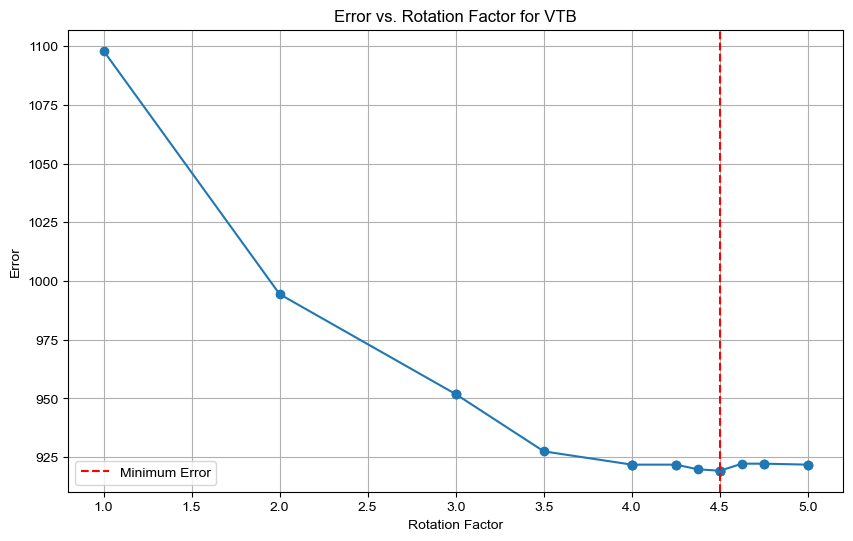

In [8]:
# print(ground_truth[50])

ground_truth_modified = np.array([ground_truth[50]])
reconstruction_VTB_modified = np.array([reconstruction_VTB[50]])
# opt_rotations_VTB = deepcallib.calculate_optimal_rotations(ground_truth_modified, reconstruction_VTB_modified, error_function, name="VTB", initial_range=[0, 4], print_errors=True)


# opt_rotations_VTB = deepcallib.calculate_optimal_rotations(ground_truth, reconstruction_VTB, error_function, name="VTB", max_iterations=4, resolution=5, initial_range=[0.5, 2], print_errors=True)
opt_rotations_VTB = deepcallib.calculate_optimal_rotations(ground_truth_modified, reconstruction_VTB_modified, error_function, name="VTB", max_iterations=4, resolution=5, initial_range=[0, 4], print_errors=True)



# opt_rotations_ML = deepcallib.calculate_optimal_rotations(ground_truth, reconstruction_ML, error_function, name="ML", initial_range=[0, 4])
# opt_rotations_NO_opt = deepcallib.calculate_optimal_rotations(ground_truth, reconstruction_NO_opt, error_function, name="NO_opt", initial_range=[0, 4])

# print(f"best number of rotations for VTB: {opt_rotations_VTB}")
# print(f"best number of rotations for ML: {opt_rotations_ML}")
# print(f"best number of rotations for no optimization: {opt_rotations_NO_opt}")


# max = 3
# multithread: 1:05
# not multithread: 43s
# multiprocess: 



# max = 4
# multithread 1:19
# not multithread 1:22

# max = 5
# multithread 1:52
# not multithread 1:51

# max = 6
# multithread 3:28
# not multithread 



################################################################################################
# best number of rotations for VTB: 1.4500000000000002
# best number of rotations for ML: 1.6750000000000003
# best number of rotations for no optimization: 1.0250000000000001

In [9]:
# best_number_of_rotation_VTB = 1.4500000000000002
# best_number_of_rotation_ML = 1.6750000000000003
# best_number_of_rotation_NO_opt = 1.0250000000000001

# best_number_of_rotation_NO_opt = 0.4500000000000001
# best_number_of_rotation_VTB = 0.75
# best_number_of_rotation_ML = 0.6500000000000001

# deepcallib.plot(np.array(ground_truth), d_l=0.001, d_h=1)

# NO_opt = deepcallib.round_3d_array(reconstruction_NO_opt, round_down_threshold=d_l, round_up_threshold=d_h)
# NO_opt = deepcallib.round_3d_array(reconstruction_NO_opt * best_number_of_rotation_NO_opt, round_down_threshold=d_l, round_up_threshold=d_h)  
# deepcallib.plot(np.array(NO_opt), d_l=0.001, d_h=1)

VTB_opt = deepcallib.round_3d_array(reconstruction_VTB*opt_rotations_VTB, round_down_threshold=d_l, round_up_threshold=d_h)  
# VTB_opt = deepcallib.round_3d_array(reconstruction_VTB * best_number_of_rotation_VTB, round_down_threshold=d_l, round_up_threshold=d_h)  
deepcallib.plot(np.array(VTB_opt), d_l=0.001, d_h=1)

# ML_opt = deepcallib.round_3d_array(reconstruction_ML*opt_rotations_ML, round_down_threshold=d_l, round_up_threshold=d_h)  
# ML_opt = deepcallib.round_3d_array(reconstruction_ML * best_number_of_rotation_ML, round_down_threshold=d_l, round_up_threshold=d_h)  
# deepcallib.plot(np.array(ML_opt), d_l=0.001, d_h=1)